In [11]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY


## Example Hardware
#### Please note that the GT have an attribute of TIME_SLICE for the round robin to work

Validating System platform: MTL...
System platform is valid!


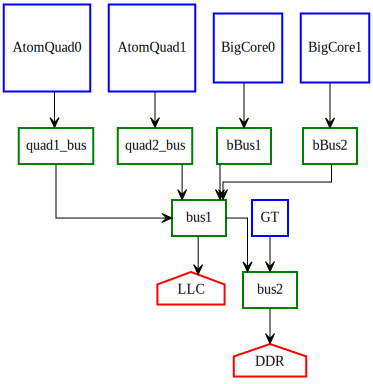

In [12]:
from models.preemptions.preemptions import RoundRobinExtension

PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.01).instance
a_clk = Clock("a_clk", 0.01)    # 10 ns
b_clk = Clock("b_clk", 0.01)    # 10 ns
g_clk = Clock("g_clk", 0.01)    # 10 ns
sys_platform.add_clock(clk)
sys_platform.add_clock(a_clk)
sys_platform.add_clock(b_clk)
sys_platform.add_clock(g_clk)

# IPs:
# - Ports
# - Drivers
# - Executing units

# Atoms
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)
    
# Big cores
bCores = dict()
for i in range(2):
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)

    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)

# GT 
gt_p = Port('p')
gt_dr = Driver('dr', g_clk)
gt_dr.attach_attribute(RoundRobinExtension.TIME_SLICE, 10)
gt_ex = ExecutingUnit('ex_u', g_clk)
gt_ex.attach_attribute(RoundRobinExtension.TIME_SLICE, 10)

gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)
sys_platform.add_bus(quad1_bus)
sys_platform.add_bus(quad2_bus)
sys_platform.add_bus(bBus1)
sys_platform.add_bus(bBus2)

# System buses
bus1 = Bus('bus1', clk, 64)
bus2 = Bus('bus2', clk, 64)
sys_platform.add_bus(bus1)
sys_platform.add_bus(bus2)

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memory(llc)
sys_platform.add_memory(ddr)

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)

sys_platform.validate_platform()
sys_platform

In [13]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

## Custom scheduler
### schedules every task by its map type

In [14]:
from asap.schedulers import SystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState

class AtomFirstScheduler(SystemScheduler):
    """
    Atom first scheduler:
        Prefers to map to Atoms first tasks w/ attribute MAP_TYPE == Core. Any task mapped to atom gets extra penalty.
        If all atoms are busy then map to CPU without any extra penalty.
    """
    def __init__(self, system_mgr, properties=None, platform_scheduler=None):
        super().__init__(system_mgr, properties, platform_scheduler)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        self._display = display

    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips

    def schedule_task(self, task, resource=None):
        """
        Schedule task according to task attribute MAP_TYPE.
        if MAP_TYPE is not defines on task then task will run unmapped
        """
        if resource is not None:
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, resource)])
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._platform_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._platform_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        elif task_map_type == 'Display':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._display)])
        else:
            return self._platform_scheduler.schedule_task(task, list())

    def on_task_finish(self, task):
        self._platform_scheduler.on_task_finish(task)


# Task graph
## Runtimes with no interferences:
#### task1: 11 us
#### task2: 20 us
#### task3: 11 us
#### task4: 1.953125 us
#### task5: 15 us

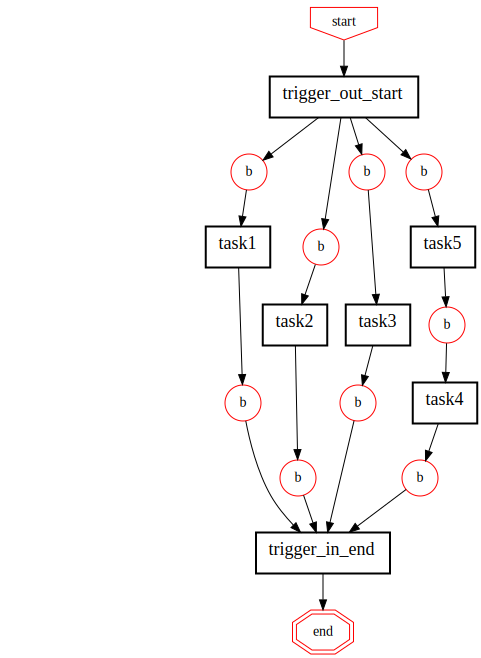

In [15]:
from asap.utils import create_rpw_task, from_pnml_file
from asap.workload import Task, Workload, TYPES
from asap.mapping import Mapping
from asap.schedulers import BlockingScheduler


start = Task('start',TYPES.START)
end = Task('end', TYPES.END)
task1 = Task('task1', type=TYPES.WRITE,write_bytes=70400)
task1.attach_attribute('MAP_TYPE', 'GT')
task1.attach_attribute('MEMORY_TARGETS', {'DDR':100})

task2 = Task('task2', type=TYPES.WRITE, write_bytes=128000)
task2.attach_attribute('MAP_TYPE', 'Core')
task2.attach_attribute('MEMORY_TARGETS', {'DDR':100})


task3 = Task('task3', type=TYPES.WRITE, write_bytes=70400)
task3.attach_attribute('MAP_TYPE', 'GT')
task3.attach_attribute('MEMORY_TARGETS', {'DDR':100})

task4 = Task('task4', type=TYPES.READ,read_bytes=12500)
task4.attach_attribute('MAP_TYPE', 'GT')
task4.attach_attribute('MEMORY_TARGETS', {'DDR':100})


task5 = Task('task5', type=TYPES.PROC, processing_cycles=1500)
task5.attach_attribute('MAP_TYPE', 'GT')
task5.attach_attribute('MEMORY_TARGETS', {'DDR':100})

workload = Workload('workload')
mapping = Mapping('mapping', workload)
workload.add_tasks([start, task1, task2, task3, task4, task5, end])
workload.connect_tasks('1', start, task1)
workload.connect_tasks('2', start, task2)
workload.connect_tasks('3', start, task3)
workload.connect_tasks('4', start, task5)
workload.connect_tasks('5', task2, end)
workload.connect_tasks('6', task3, end)
workload.connect_tasks('7', task1, end)
workload.connect_tasks('8', task4, end)
workload.connect_tasks('9', task5, task4)


workload.to_pnml_model()

# Results with round robin extension
### Please be advised that you need to set the platform scheduler as the RoundRobinScheduler
### and that the round robin extension should be the last between the extensions

In [16]:
from speedsim import SpeedSim
from models.fabric.multi_memory import MultiMemoryExtension
from models.preemptions.preemptions import RoundRobinExtension, RoundRobinScheduler

sys_platform.reset()
speedsim = SpeedSim(sys_platform, workload, mapping)
speedsim.set_system_scheduler(AtomFirstScheduler)
speedsim.set_platform_scheduler(RoundRobinScheduler)
speedsim.add_extension('MultiMemory', MultiMemoryExtension)
speedsim.add_extension('RoundRobin', RoundRobinExtension)
res = speedsim.simulate(1000000)

In [17]:
from post_processing.tables import show_interactive_table

show_interactive_table(res)

In [18]:
from post_processing.graphs import create_task_analysis_fig

show(create_task_analysis_fig(res))